In [45]:
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [46]:
# 데이터 전처리 함수들
def df_treat(name):
    """데이터 정규화 및 전처리"""
    df = pd.read_csv(name)
    ndf = pd.DataFrame()
    range_mm={
        'V': {'min':df['V'].min()*0.8, 'max': df['V'].max()*1.2},
        'E': {'min':df['E'].min()*0.8, 'max': df['E'].max()*1.2},
        'VF': {'min':df['VF'].min()*0.8, 'max': df['VF'].max()*1.2},
        'VA': {'min':df['VA'].min()*0.8, 'max': df['VA'].max()*1.2},
        'VB': {'min':df['VB'].min()*0.8, 'max': df['VB'].max()*1.2},
        'CFLA': {'min':0, 'max': df['CFLA'].max()*1.2},
        'CALA': {'min':0, 'max': df['CALA'].max()*1.2},
        'CFK': {'min':0, 'max': df['CFK'].max()*1.2},
        'CBK': {'min':0, 'max': df['CBK'].max()*1.2},
        'I': {'min':0, 'max': df['I'].max()*1.2},
    }
    ndf['exp'] = df['exp']; ndf['t'] = df['t']

    for col in ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']:
        if col in range_mm:
            ndf[col] = (df[col] - range_mm[col]['min'])/(range_mm[col]['max'] - range_mm[col]['min'])
        else:
            ndf[col] = df[col]

    exp_num_list = sorted(ndf['exp'].unique())
    return df, ndf, range_mm, exp_num_list

def seq_data(ndf, exp_num_list):
    """시퀀스 데이터 생성"""
    seq = []
    feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    
    for exp in exp_num_list:
        exp_df = ndf[ndf['exp'] == exp]
        seq.append(exp_df[feature_cols].values)
    
    return seq

def pad_seq(seq):
    """시퀀스 패딩"""
    max_len = max([len(s) for s in seq])
    seq_len = [len(s) for s in seq]
    pad_seq = pad_sequence([torch.tensor(s) for s in seq], batch_first=True, padding_value=-1)
    return pad_seq, seq_len, max_len

def gen_dataset(pad_seq, seq_len):
    """데이터셋 생성"""
    input_tensor = pad_seq.float()
    seq_len_tensor = torch.tensor(seq_len)
    dataset = TensorDataset(input_tensor, seq_len_tensor)
    return dataset

In [47]:
# 모델 클래스 정의 (기존 학습된 모델과 동일한 구조)

class LayerNormLSTM(nn.Module):
    """LSTM layer with layer normalization applied to gates"""
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node

        self.w_i = nn.Linear(input_node, 4 * hidden_node, bias=False)
        self.w_h = nn.Linear(hidden_node, 4 * hidden_node, bias=False)

        self.ln_i = nn.LayerNorm(hidden_node)
        self.ln_h = nn.LayerNorm(hidden_node)
        self.ln_g = nn.LayerNorm(hidden_node)
        self.ln_o = nn.LayerNorm(hidden_node)

        self.ln_c = nn.LayerNorm(hidden_node)

    def forward(self, input, hidden):
        h_prev, c_prev = hidden

        gi = self.w_i(input)
        gh = self.w_h(h_prev)
        i_i, i_f, i_g, i_o = gi.chunk(4, dim=-1)
        h_i, h_f, h_g, h_o = gh.chunk(4, dim=-1)

        i_g = torch.sigmoid(self.ln_i(i_i + h_i))
        f_g = torch.sigmoid(self.ln_h(i_f + h_f))
        g_g = torch.tanh(self.ln_g(i_g + h_g))
        o_g = torch.sigmoid(self.ln_o(i_o + h_o))

        c_new = f_g * c_prev + i_g * g_g
        c_new = self.ln_c(c_new)

        h_new = o_g * torch.tanh(c_new)

        return h_new, c_new
class StateExtr(nn.Module):
    """State Extractor using LayerNorm LSTM"""
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for _ in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)
        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        batch_size, max_len, input_node = x.size()
        device = x.device

        h_states = []
        c_states = []
        for _ in range(self.n_layer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        
        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]

            layer_input = x_t
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))

                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new

                if layer_idx < len(self.lstm_cells) - 1:
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new

            outputs.append(layer_input)
        
        output_tensor = torch.stack(outputs, dim=1)
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        normalized = self.final_layer_norm(masked_output)
        return self.final_dropout(normalized)

# Stateful State Extractor for Free Running Model
class StatefulStateExtr(nn.Module):
    """Hidden state를 유지하며 sequential 처리하는 State Extractor"""
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for _ in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)
        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)
        
        # Hidden states를 클래스 변수로 관리
        self.h_states = None
        self.c_states = None

    def reset_states(self, batch_size=None, device=None):
        """새로운 시퀀스 시작 시 hidden state 초기화"""
        if batch_size is not None and device is not None:
            self.h_states = []
            self.c_states = []
            for _ in range(self.n_layer):
                self.h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
                self.c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        else:
            self.h_states = None
            self.c_states = None

    def forward_single_timestep(self, x_t):
        """단일 시점 처리 - hidden state 유지"""
        batch_size = x_t.size(0)
        device = x_t.device
        
        # 첫 번째 호출 시 hidden state 초기화
        if self.h_states is None:
            self.reset_states(batch_size, device)

        layer_input = x_t
        for layer_idx, lstm_cell in enumerate(self.lstm_cells):
            h_new, c_new = lstm_cell(layer_input, (self.h_states[layer_idx], self.c_states[layer_idx]))

            # Hidden state 업데이트
            self.h_states[layer_idx] = h_new
            self.c_states[layer_idx] = c_new

            if layer_idx < len(self.lstm_cells) - 1:
                layer_input = self.dropout(h_new)
            else:
                layer_input = h_new

        # 정규화 및 드롭아웃 적용
        normalized = self.final_layer_norm(layer_input)
        return self.final_dropout(normalized)

    def forward(self, x, seq_len):
        """기존 teacher forcing 방식과 호환성 유지"""
        batch_size, max_len, input_node = x.size()
        device = x.device

        # Teacher forcing 모드에서는 매번 hidden state 초기화
        self.reset_states(batch_size, device)
        
        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]
            output = self.forward_single_timestep(x_t)
            outputs.append(output)
        
        output_tensor = torch.stack(outputs, dim=1)
        
        # 마스킹 적용
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        return masked_output

In [48]:
class PhysicalChangeDecoder(nn.Module):
    """Physical Change Decoder"""
    def __init__(self, input_node, output_node, n_layer, hidden_node, dropout):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(input_node, hidden_node))
        self.layers.append(nn.LayerNorm(hidden_node))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        for i in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_node, hidden_node))
            self.layers.append(nn.LayerNorm(hidden_node))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        self.layers.append(nn.Linear(hidden_node, output_node))
    
    def forward(self, hidden_states):
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x

class CurrentPredictor(nn.Module):
    """Current Predictor"""
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_node, hidden_node))
        self.layers.append(nn.LayerNorm(hidden_node))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))
        
        for i in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_node, hidden_node))
            self.layers.append(nn.LayerNorm(hidden_node))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))
        
        self.layers.append(nn.Linear(hidden_node, 1))
    
    def forward(self, new_state):
        x = new_state
        for layer in self.layers:
            x = layer(x)
        return x

In [49]:
class PhysicsConstraintLayer(nn.Module):
    """Physics Constraint Layer with Current Prediction"""
    def __init__(self, range_mm, current_predictor, eps=1e-2):
        super().__init__()
        self.sps = eps
        self.current_predictor = current_predictor
        self.register_buffer('range_mm_tensor', self._convert_range_to_tensor(range_mm))

    def _convert_range_to_tensor(self, range_mm):
        feature_names = ['V','E','VF','VA','VB','CFLA','CALA','CFK','CBK','I']
        ranges = torch.zeros(len(feature_names),2)

        for i, name in enumerate(feature_names):
            if name in range_mm:
                ranges[i, 0] = range_mm[name]['min']
                ranges[i, 1] = range_mm[name]['max']
        
        return ranges
    
    def normalize(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return (data - min_val) / (max_val - min_val)

    def denormalize(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return data * (max_val - min_val) + min_val

    def forward(self, physical_changes, current_state):
        V_idx, E_idx, VF_idx, VA_idx, VB_idx = 0, 1, 2, 3, 4
        CFLA_idx, CALA_idx, CFK_idx, CBK_idx, I_idx = 5, 6, 7, 8, 9

        VF = self.denormalize(current_state[..., 2:3], VF_idx)
        VA = self.denormalize(current_state[..., 3:4], VA_idx)
        VB = self.denormalize(current_state[..., 4:5], VB_idx)
        CFLA = self.denormalize(current_state[..., 5:6], CFLA_idx)
        CALA = self.denormalize(current_state[..., 6:7], CALA_idx)
        CFK = self.denormalize(current_state[..., 7:8], CFK_idx)
        CBK = self.denormalize(current_state[..., 8:9], CBK_idx)

        dVA = physical_changes[..., 0:1]
        dVB = physical_changes[..., 1:2]
        rratio = physical_changes[..., 2:3]
        dNBK = physical_changes[..., 3:4]

        ratio = torch.sigmoid(rratio)
        dNALA = ratio * dNBK

        NFLA = CFLA * VF
        NALA = CALA * VA
        NFK = CFK * VF
        NBK = CBK * VB

        nVF = VF - dVA - dVB
        nVA = VA + dVA
        nVB = VB + dVB

        nVF = torch.clamp(nVF, min=self.sps)
        nVA = torch.clamp(nVA, min=self.sps)
        nVB = torch.clamp(nVB, min=self.sps)
        
        nNFLA = NFLA - torch.clamp(dNALA, min=0.0)
        nNALA = NALA + torch.clamp(dNALA, min=0.0)
        nNFK = NFK - torch.clamp(dNBK, min=0.0)
        nNBK = NBK + torch.clamp(dNBK, min=0.0)

        nNFLA = torch.clamp(nNFLA, min=0.0)
        nNALA = torch.clamp(nNALA, min=0.0)
        nNFK = torch.clamp(nNFK, min=0.0)
        nNBK = torch.clamp(nNBK, min=0.0)

        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCFK = nNFK / nVF
        nCBK = nNBK / nVB

        V = current_state[..., 0:1]
        E = current_state[..., 1:2]
        nVF_norm = self.normalize(nVF, VF_idx)
        nVA_norm = self.normalize(nVA, VA_idx)
        nVB_norm = self.normalize(nVB, VB_idx)
        nCFLA_norm = self.normalize(nCFLA, CFLA_idx)
        nCALA_norm = self.normalize(nCALA, CALA_idx)
        nCFK_norm = self.normalize(nCFK, CFK_idx)
        nCBK_norm = self.normalize(nCBK, CBK_idx)

        temp_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm
        ], dim=-1)
        
        nI_pred_norm = self.current_predictor(temp_state)
        
        nI_real = self.denormalize(nI_pred_norm, I_idx)
        nI_real = torch.clamp(nI_real, min=0.0)
        nI_norm = self.normalize(nI_real, I_idx)

        next_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm, nI_norm
        ], dim=-1)
        
        return next_state

In [50]:
class BMEDAutoregressiveModel(nn.Module):
    """통합 BMED Autoregressive Model - Teacher Forcing & Free Running 모드 지원"""
    def __init__(self, state_extr_params, decoder_params, current_predictor_params, range_mm):
        super().__init__()
        self.state_extr = StateExtr(**state_extr_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.current_predictor = CurrentPredictor(**current_predictor_params)
        self.physics_constraint = PhysicsConstraintLayer(range_mm, self.current_predictor)
        
        # Free running을 위한 hidden state 관리
        self._hidden_states = None
        self._cell_states = None

    def _reset_hidden_states(self, batch_size, device):
        """Free running 시작 시 hidden state 초기화"""
        self._hidden_states = []
        self._cell_states = []
        for _ in range(self.state_extr.n_layer):
            self._hidden_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))
            self._cell_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))

    def teacher_forcing_forward(self, x, seq_len):
        """Teacher Forcing 모드: 기존 방식"""
        hidden_states = self.state_extr(x, seq_len)
        physical_changes = self.physical_decoder(hidden_states)
        new_x = self.physics_constraint(physical_changes, x)
        return new_x

    def free_running_forward(self, initial_state, target_length):
        """
        Free Running 모드: 초기 상태만으로 전체 시퀀스 생성
        Args:
            initial_state: [batch, features] - 초기 상태 (모든 10개 특성 포함)
            target_length: int - 예측할 시퀀스 길이
        Returns:
            predictions: [batch, target_length, features] - 예측된 전체 시퀀스
        """
        batch_size = initial_state.size(0)
        feature_size = initial_state.size(1)
        device = initial_state.device
        
        # Hidden state 초기화
        self._reset_hidden_states(batch_size, device)
        
        # 예측 결과 저장
        predictions = torch.zeros(batch_size, target_length, feature_size, device=device)
        current_state = initial_state.clone()
        
        for t in range(target_length):
            predictions[:, t, :] = current_state
            
            if t < target_length - 1:
                # 현재 상태에서 I(전류) 제거하여 LSTM 입력 생성 (9개 특성)
                lstm_input = current_state[:, :-1]  # [batch, 9]
                
                # LSTM forward with hidden state maintenance
                hidden_output = self._forward_lstm_single_step(lstm_input)
                
                # Physical change 예측
                physical_changes = self.physical_decoder(hidden_output.unsqueeze(1))  # [batch, 1, output]
                
                # Physics constraint로 다음 상태 계산
                current_state_expanded = current_state.unsqueeze(1)  # [batch, 1, features]
                next_state = self.physics_constraint(physical_changes, current_state_expanded)
                current_state = next_state.squeeze(1)  # [batch, features]
        
        return predictions

    def _forward_lstm_single_step(self, x_t):
        """단일 시점 LSTM forward (hidden state 유지)"""
        layer_input = x_t
        
        for layer_idx, lstm_cell in enumerate(self.state_extr.lstm_cells):
            h_new, c_new = lstm_cell(layer_input, 
                                   (self._hidden_states[layer_idx], self._cell_states[layer_idx]))
            
            # Hidden state 업데이트
            self._hidden_states[layer_idx] = h_new
            self._cell_states[layer_idx] = c_new
            
            # Dropout 적용 (마지막 layer 제외)
            if layer_idx < len(self.state_extr.lstm_cells) - 1:
                layer_input = self.state_extr.dropout(h_new)
            else:
                layer_input = h_new
        
        # 최종 정규화 및 드롭아웃
        normalized = self.state_extr.final_layer_norm(layer_input)
        return self.state_extr.final_dropout(normalized)

    def forward(self, x, seq_len=None, mode='teacher_forcing', target_length=None):
        """
        통합 forward 메소드
        Args:
            x: 입력 데이터
            seq_len: 시퀀스 길이 (teacher forcing 모드에서 사용)
            mode: 'teacher_forcing' 또는 'free_running'
            target_length: free running에서 예측할 길이
        """
        if mode == 'teacher_forcing':
            if seq_len is None:
                raise ValueError("seq_len은 teacher_forcing 모드에서 필수입니다")
            return self.teacher_forcing_forward(x, seq_len)
        
        elif mode == 'free_running':
            if target_length is None:
                raise ValueError("target_length는 free_running 모드에서 필수입니다")
            return self.free_running_forward(x, target_length)
        
        else:
            raise ValueError(f"지원하지 않는 모드: {mode}. 'teacher_forcing' 또는 'free_running'을 사용하세요.")

print("✅ 통합된 BMEDAutoregressiveModel 구현 완료!")

✅ 통합된 BMEDAutoregressiveModel 구현 완료!


In [51]:
# 데이터 준비 함수들 - Teacher Forcing & Free Running 지원

def tf_data(input_seq, seq_len):
    """
    Teacher Forcing용 데이터 준비 (원본 bmed_tf_learning.ipynb와 동일)
    
    Args:
        input_seq: [batch, seq_len, features] - 전체 시퀀스 (10개 특성)
        seq_len: [batch] - 각 시퀀스의 실제 길이
    
    Returns:
        inputs: [batch, seq_len-1, 9] - LSTM 입력 (I 제외한 9개 특성)
        targets: [batch, seq_len-1, 10] - 예측 타겟 (전체 10개 특성)
        target_seq_len: [batch] - 타겟 시퀀스 길이 (seq_len - 1)
    """
    # 입력: 시퀀스의 마지막 시점 제외, I(전류) 특성 제외
    inputs = input_seq[:, :-1, :-1]  # [batch, seq_len-1, 9]
    
    # 타겟: 시퀀스의 첫 번째 시점 제외, 모든 특성 포함
    targets = input_seq[:, 1:, :]    # [batch, seq_len-1, 10]
    
    # 타겟 시퀀스 길이
    target_seq_len = seq_len - 1
    
    return inputs, targets, target_seq_len

def fr_data(input_seq, seq_len):
    """
    Free Running용 데이터 준비
    
    Args:
        input_seq: [batch, seq_len, features] - 전체 시퀀스 (10개 특성)
        seq_len: [batch] - 각 시퀀스의 실제 길이
    
    Returns:
        initial_states: [batch, 10] - 초기 상태 (전체 10개 특성)
        targets: [batch, seq_len, 10] - 예측 타겟 (전체 시퀀스)
        target_lengths: [batch] - 예측할 시퀀스 길이
    """
    # 초기 상태: 첫 번째 시점
    initial_states = input_seq[:, 0, :]  # [batch, 10]
    
    # 타겟: 전체 시퀀스
    targets = input_seq  # [batch, seq_len, 10]
    
    # 예측할 길이
    target_lengths = seq_len  # [batch]
    
    return initial_states, targets, target_lengths

def masked_mse_loss(pred, target, seq_len):
    """Masked MSE Loss function"""
    batch_size, max_len, features = pred.shape
    seq_len_cpu = seq_len.detach().cpu().long()

    mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
    mask = mask.float().to(pred.device)

    loss = F.mse_loss(pred, target, reduction='none')
    masked_loss = loss * mask.unsqueeze(-1)

    total_loss = masked_loss.sum()
    total_elements = mask.sum()

    masked_loss = total_loss / total_elements
    return masked_loss

print("✅ 데이터 준비 함수들 구현 완료!")
print("   - tf_data: Teacher Forcing용 입력/타겟 준비")
print("   - fr_data: Free Running용 초기상태/타겟 준비") 
print("   - masked_mse_loss: 마스킹된 MSE 손실 함수")

✅ 데이터 준비 함수들 구현 완료!
   - tf_data: Teacher Forcing용 입력/타겟 준비
   - fr_data: Free Running용 초기상태/타겟 준비
   - masked_mse_loss: 마스킹된 MSE 손실 함수


In [52]:
# 데이터 로드 및 전처리
data_path = "BMED_DATA_AG.csv"
print(f"📊 데이터 로드 중: {data_path}")
df, ndf, current_range_mm, exp_num_list = df_treat(data_path)

# 시퀀스 데이터 생성
seq = seq_data(ndf, exp_num_list)
pad_sequences, seq_lengths, max_length = pad_seq(seq)
dataset = gen_dataset(pad_sequences, seq_lengths)
dataloader = DataLoader(dataset, batch_size=5, shuffle=False)

print(f"   - 실험 수: {len(exp_num_list)}")
print(f"   - 최대 시퀀스 길이: {max_length}")

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 사용 중인 장치: {device}")

# 모델 파일 경로
model_path = "BMED_TF_250909.pth"

# 저장된 모델 체크포인트 로드
print(f"📥 모델 파일 로드 중: {model_path}")
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

# 모델 설정 정보 확인
model_config = checkpoint['model_config']
state_extr_params = model_config['state_extr_params']
decoder_params = model_config['decoder_params']
current_predictor_params = model_config['current_predictor_params']
checkpoint_range_mm = model_config['range_mm']  # 체크포인트의 range_mm 별도 저장

# ✅ 현재 데이터의 range_mm 사용 (체크포인트 range_mm으로 덮어쓰지 않음)
range_mm = current_range_mm
print("✅ 모델 설정 정보 발견:")
print(f"   - State Extractor: input={state_extr_params['input_node']}, hidden={state_extr_params['hidden_node']}, layers={state_extr_params['n_layer']}, dropout={state_extr_params['dropout']}")
print(f"   - Decoder: input={decoder_params['input_node']}, hidden={decoder_params['hidden_node']}, layers={decoder_params['n_layer']}, dropout={decoder_params['dropout']}")
print(f"   - Current Predictor: input={current_predictor_params['input_node']}, hidden={current_predictor_params['hidden_node']}, layers={current_predictor_params['n_layer']}, dropout={current_predictor_params['dropout']}")
print(f"🔧 Range_mm 사용: 현재 데이터 기준 (TF 노트북과 동일 스케일)")

📊 데이터 로드 중: BMED_DATA_AG.csv
   - 실험 수: 15
   - 최대 시퀀스 길이: 37
🔧 사용 중인 장치: cuda
📥 모델 파일 로드 중: BMED_TF_250909.pth
✅ 모델 설정 정보 발견:
   - State Extractor: input=9, hidden=64, layers=5, dropout=0.1
   - Decoder: input=64, hidden=16, layers=2, dropout=0.2
   - Current Predictor: input=9, hidden=48, layers=2, dropout=0.3
🔧 Range_mm 사용: 현재 데이터 기준 (TF 노트북과 동일 스케일)


In [53]:
# Pure Free Running Transfer Learning - TF 가중치를 초기값으로 활용한 FR 전용 학습

print("🎯 Pure Free Running Transfer Learning 시작")
print("="*60)

# 통합 모델 생성 및 pretrained 가중치 로드
print("📦 통합 모델 생성 중...")
unified_model = BMEDAutoregressiveModel(
    state_extr_params=state_extr_params,
    decoder_params=decoder_params, 
    current_predictor_params=current_predictor_params,
    range_mm=range_mm  # ✅ 현재 데이터의 range_mm 사용
).to(device)

# Pretrained 가중치를 Initial Connection Weight으로 로드
print("⚡ Pretrained TF 가중치를 Initial Connection Weight으로 로드 중...")
unified_model.load_state_dict(checkpoint['model_state_dict'])
print("✅ Pretrained TF 가중치 로드 완료!")

# Pure Free Running Loss 함수 정의 (Teacher Forcing 계산 완전 배제)
def pure_free_running_loss(model, initial_states, targets, target_lengths):
    """Pure Free Running 모드 전용 손실 함수 (TF 계산 없음)"""
    batch_size = initial_states.size(0)
    total_loss = 0.0
    valid_predictions = 0
    
    for i in range(batch_size):
        # 개별 시퀀스에 대해 Free Running 예측
        single_initial = initial_states[i:i+1, :]  # [1, 10]
        single_target = targets[i, :target_lengths[i], :]  # [seq_len, 10]
        length = target_lengths[i].item()
        
        # Free Running 예측만 수행
        prediction = model(single_initial, mode='free_running', target_length=length)
        prediction = prediction.squeeze(0)  # [seq_len, 10]
        
        # 손실 계산 (전체 시퀀스)
        seq_loss = F.mse_loss(prediction, single_target)
        total_loss += seq_loss
        valid_predictions += 1
    
    return total_loss / valid_predictions if valid_predictions > 0 else torch.tensor(0.0)

# Noam Scheduler 클래스 정의 (bmed_tf_learning.ipynb와 동일)
class NoamScheduler:
    def __init__(self, optimizer, model_size, warmup_epochs, factor=1.0):
        self.optimizer = optimizer
        self.model_size = model_size
        self.warmup_epochs = warmup_epochs
        self.factor = factor
        self.epoch_num = 0

    def step_epoch(self):
        self.epoch_num += 1
        lr = self.factor * (
            self.model_size ** (-0.5) *
            min(self.epoch_num ** (-0.5), self.epoch_num * self.warmup_epochs ** (-1.5))
        )
    
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

# Pure Free Running Transfer Learning 설정
print("\n🔧 Pure Free Running Transfer Learning 설정:")
num_epochs = 1000  # Transfer Learning용 에포크 수
print(f"   - Transfer Learning 에포크: {num_epochs:,}")
print("   - 학습 방식: Pure Free Running Only (TF 계산 완전 배제)")

# ReduceLROnPlateau Scheduler 사용 (Transfer Learning에 적합)
optimizer = torch.optim.AdamW(unified_model.parameters(), lr=1e-4)  # 적당한 초기 learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.8, patience=100, min_lr=1e-6
)

print(f"   - Initial Learning Rate: 1e-4")
print(f"   - Optimizer: AdamW")
print(f"   - Scheduler: ReduceLROnPlateau (factor=0.8, patience=100)")

# 전체 데이터 사용 (data split 없음 - bmed_tf_learning.ipynb와 동일)
train_dataloader = DataLoader(dataset, batch_size=5, shuffle=True)  # Batch size를 5로 복원
print(f"   - 배치 크기: {train_dataloader.batch_size}")
print(f"   - 전체 데이터 사용 (Data split 없음)")
print(f"   - 총 배치 수: {len(train_dataloader)}")

print("="*60)

# Pure Free Running Transfer Learning 실행
best_fr_loss = float('inf')
best_epoch = 0
train_losses = []
learning_rates = []

print("🚀 Pure Free Running Transfer Learning 시작...")
print("📊 Progress: [Epoch | FR Loss | LR | Status]")

for epoch in range(num_epochs):
    unified_model.train()
    epoch_fr_loss = 0.0
    valid_batches = 0
    
    for batch_idx, (input_seq, seq_len) in enumerate(train_dataloader):
        try:
            input_seq = input_seq.to(device)
            seq_len = seq_len.to(device)
            
            optimizer.zero_grad()
            
            # Free Running 데이터 준비
            fr_initial_states, fr_targets, fr_lengths = fr_data(input_seq, seq_len)
            
            # Pure Free Running Loss 계산 (TF 계산 완전 배제)
            fr_loss = pure_free_running_loss(unified_model, fr_initial_states, fr_targets, fr_lengths)
            
            # Gradient 계산 및 업데이트
            fr_loss.backward()
            torch.nn.utils.clip_grad_norm_(unified_model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # 손실 누적
            epoch_fr_loss += fr_loss.item()
            valid_batches += 1
            
        except Exception as e:
            print(f"❌ Batch {batch_idx} 오류: {str(e)}")
            continue
    
    if valid_batches == 0:
        print("❌ 유효한 배치가 없습니다.")
        break
    
    # 평균 손실 계산
    avg_fr_loss = epoch_fr_loss / valid_batches
    
    # ReduceLROnPlateau 스케줄러 업데이트
    scheduler.step(avg_fr_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # 기록 저장
    train_losses.append(avg_fr_loss)
    learning_rates.append(current_lr)
    
    # Best 모델 확인 (Free Running Loss 기준)
    if avg_fr_loss < best_fr_loss:
        best_fr_loss = avg_fr_loss
        best_epoch = epoch + 1
        best_status = " ★ BEST FR"
        
        # Best model 저장 - BMED_FR_{date}.pth 형식
        from datetime import datetime
        today = datetime.now().strftime("%y%m%d")
        model_filename = f"BMED_FR_{today}.pth"
        torch.save({
            'model_state_dict': unified_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': best_epoch,
            'best_fr_loss': best_fr_loss,
            'model_config': {
                'state_extr_params': state_extr_params,
                'decoder_params': decoder_params,
                'current_predictor_params': current_predictor_params,
                'range_mm': range_mm  # ✅ 현재 데이터의 range_mm 저장
            },
            'pure_fr_transfer_config': {
                'base_model': model_path,
                'training_mode': 'pure_free_running_only',
                'tf_excluded': True,
                'num_epochs': num_epochs,
                'scheduler_type': 'ReduceLROnPlateau',
                'initial_lr': 1e-4,
                'factor': 0.8,
                'patience': 100
            }
        }, model_filename)
    else:
        best_status = ""
    
    # 진행 상황 출력
    if (epoch + 1) % 50 == 0 or epoch < 10:  # 처음 10 epoch과 50 epoch마다 출력
        print(f"Epoch {epoch+1:5d}: FR Loss={avg_fr_loss:.6f}, LR={current_lr:.2e}{best_status}")
        if best_status:
            print(f"          ✓ Best FR Loss: {best_fr_loss:.6f} → Saved as BMED_FR_{today}.pth")

print(f"\n🎉 Pure Free Running Transfer Learning 완료!")
print("="*60)
print(f"📊 최종 결과:")
print(f"   - Best Epoch: {best_epoch}")
print(f"   - Best Free Running Loss: {best_fr_loss:.6f}")
print(f"   - Final FR Loss: {train_losses[-1]:.6f}")
print(f"   - Final Learning Rate: {learning_rates[-1]:.2e}")
print(f"   - Total Training Batches: {len(train_dataloader) * num_epochs:,}")
print("="*60)

# 모델 파일 저장 확인
today = datetime.now().strftime("%y%m%d")
model_filename = f"BMED_FR_{today}.pth"
print(f"✅ Pure Free Running 모델 저장: {model_filename}")
print(f"   - 베이스 모델: {model_path} (TF 가중치)")
print(f"   - 학습 방식: Pure Free Running Only")
print(f"   - Teacher Forcing: 완전 배제")
print(f"   - 초기 가중치: Pretrained TF weights")
print(f"   - Scheduler: ReduceLROnPlateau")
print(f"   - Range_mm: 현재 데이터 기준 (TF 노트북과 동일)")

🎯 Pure Free Running Transfer Learning 시작
📦 통합 모델 생성 중...
⚡ Pretrained TF 가중치를 Initial Connection Weight으로 로드 중...
✅ Pretrained TF 가중치 로드 완료!

🔧 Pure Free Running Transfer Learning 설정:
   - Transfer Learning 에포크: 1,000
   - 학습 방식: Pure Free Running Only (TF 계산 완전 배제)
   - Initial Learning Rate: 1e-4
   - Optimizer: AdamW
   - Scheduler: ReduceLROnPlateau (factor=0.8, patience=100)
   - 배치 크기: 5
   - 전체 데이터 사용 (Data split 없음)
   - 총 배치 수: 3
🚀 Pure Free Running Transfer Learning 시작...
📊 Progress: [Epoch | FR Loss | LR | Status]
Epoch     1: FR Loss=0.001737, LR=1.00e-04 ★ BEST FR
          ✓ Best FR Loss: 0.001737 → Saved as BMED_FR_250910.pth
Epoch     2: FR Loss=0.001688, LR=1.00e-04 ★ BEST FR
          ✓ Best FR Loss: 0.001688 → Saved as BMED_FR_250910.pth
Epoch     3: FR Loss=0.001634, LR=1.00e-04 ★ BEST FR
          ✓ Best FR Loss: 0.001634 → Saved as BMED_FR_250910.pth
Epoch     4: FR Loss=0.001693, LR=1.00e-04
Epoch     5: FR Loss=0.001423, LR=1.00e-04 ★ BEST FR
          ✓ Best FR

KeyboardInterrupt: 

🎯 Teacher Forcing vs Free Running 전체 실험 비교 시각화 (각각의 모델 사용)
📥 Teacher Forcing 모델 로드 중: BMED_TF_250909.pth
✅ Teacher Forcing 모델 로드 완료!
📥 Free Running 모델 로드 중: BMED_FR_250909.pth
✅ Free Running 모델 로드 완료!
✅ 15개 실험에 대한 예측 완료


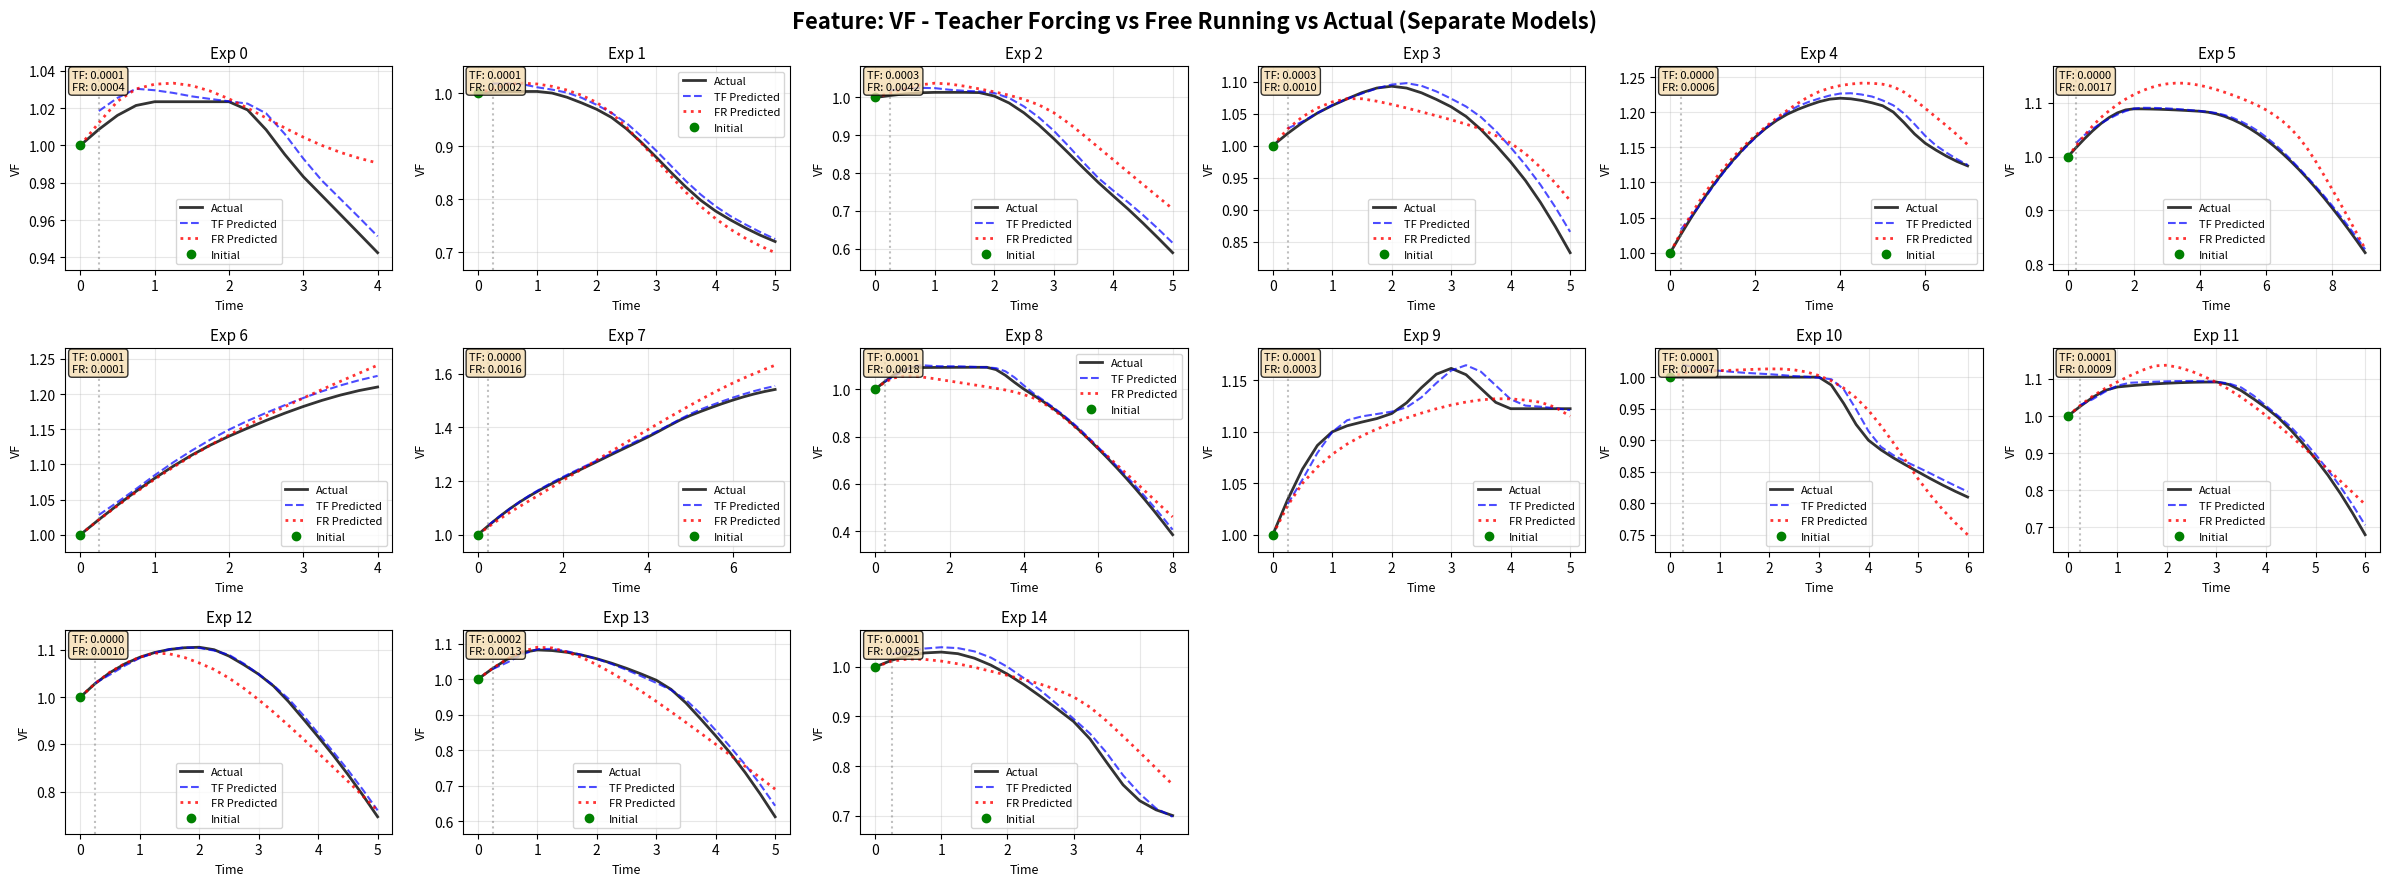

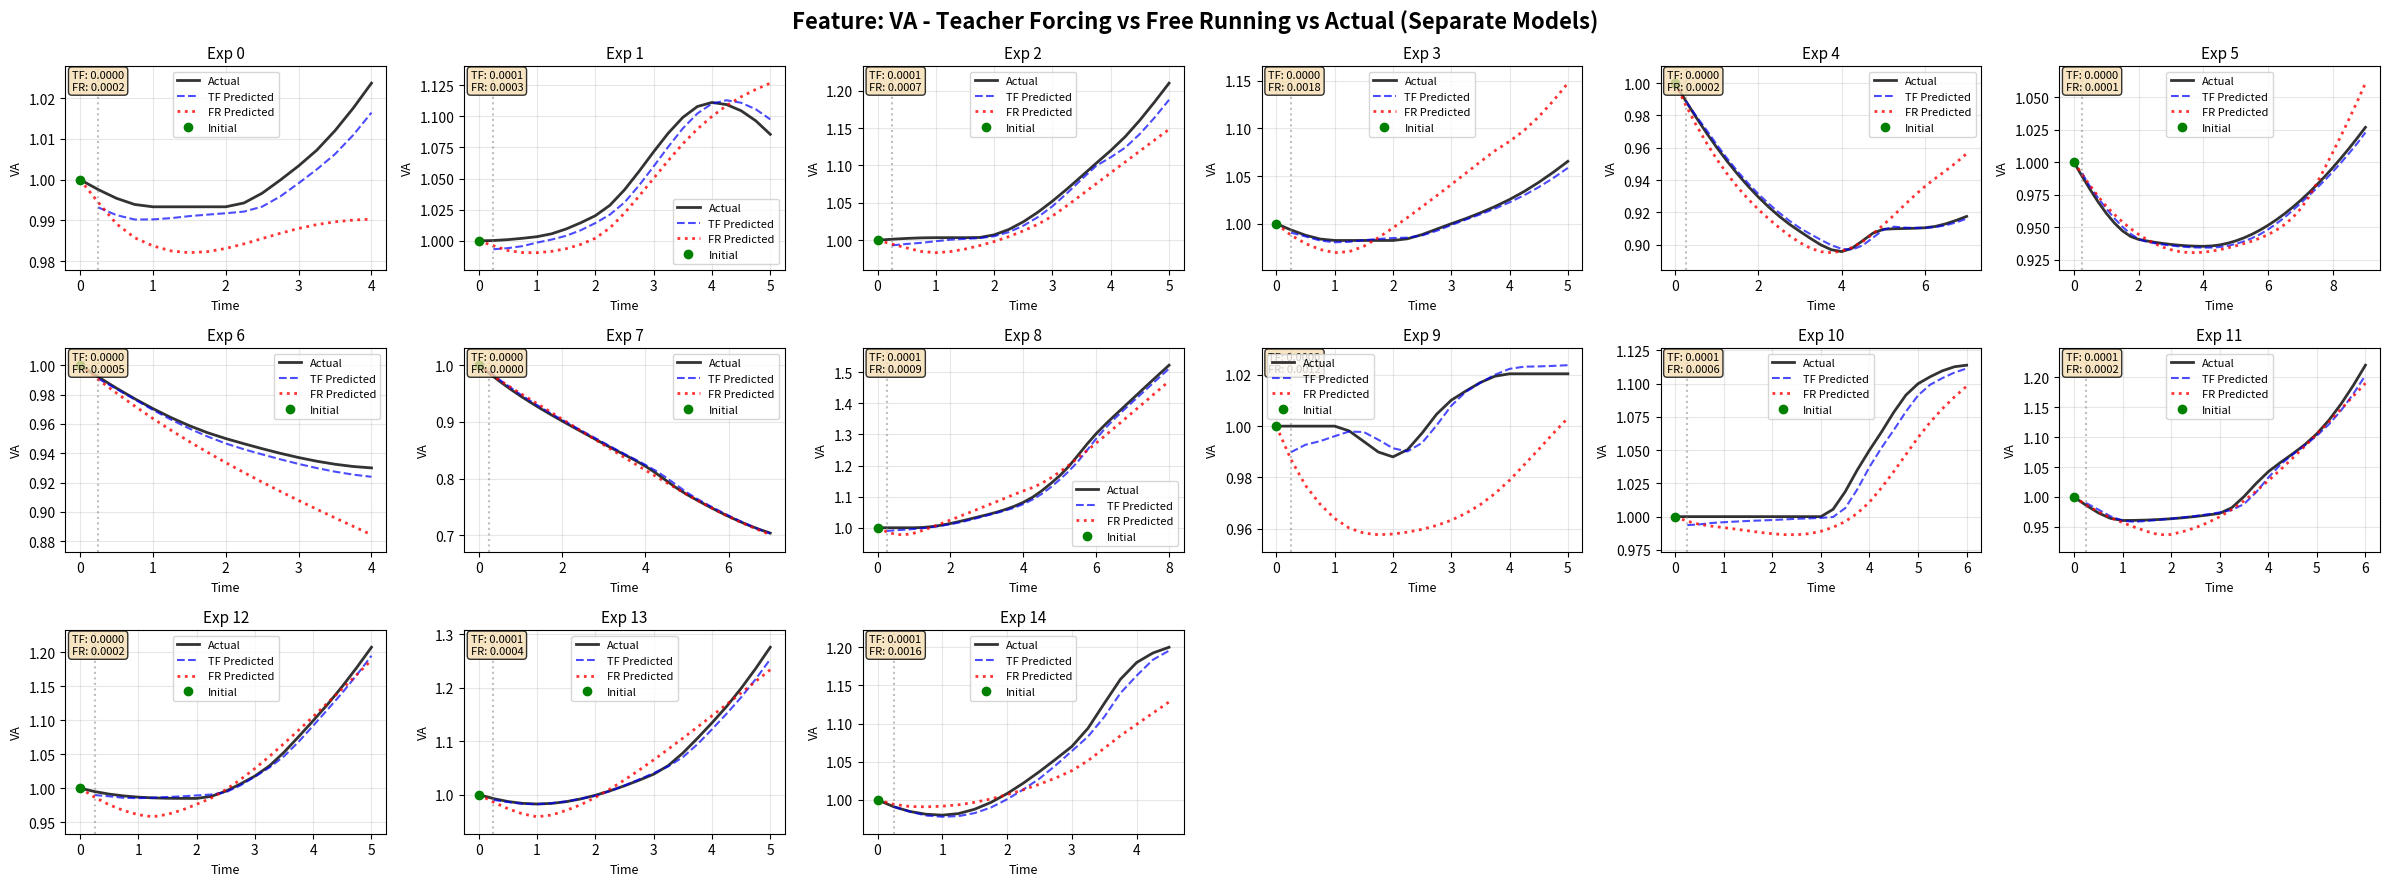

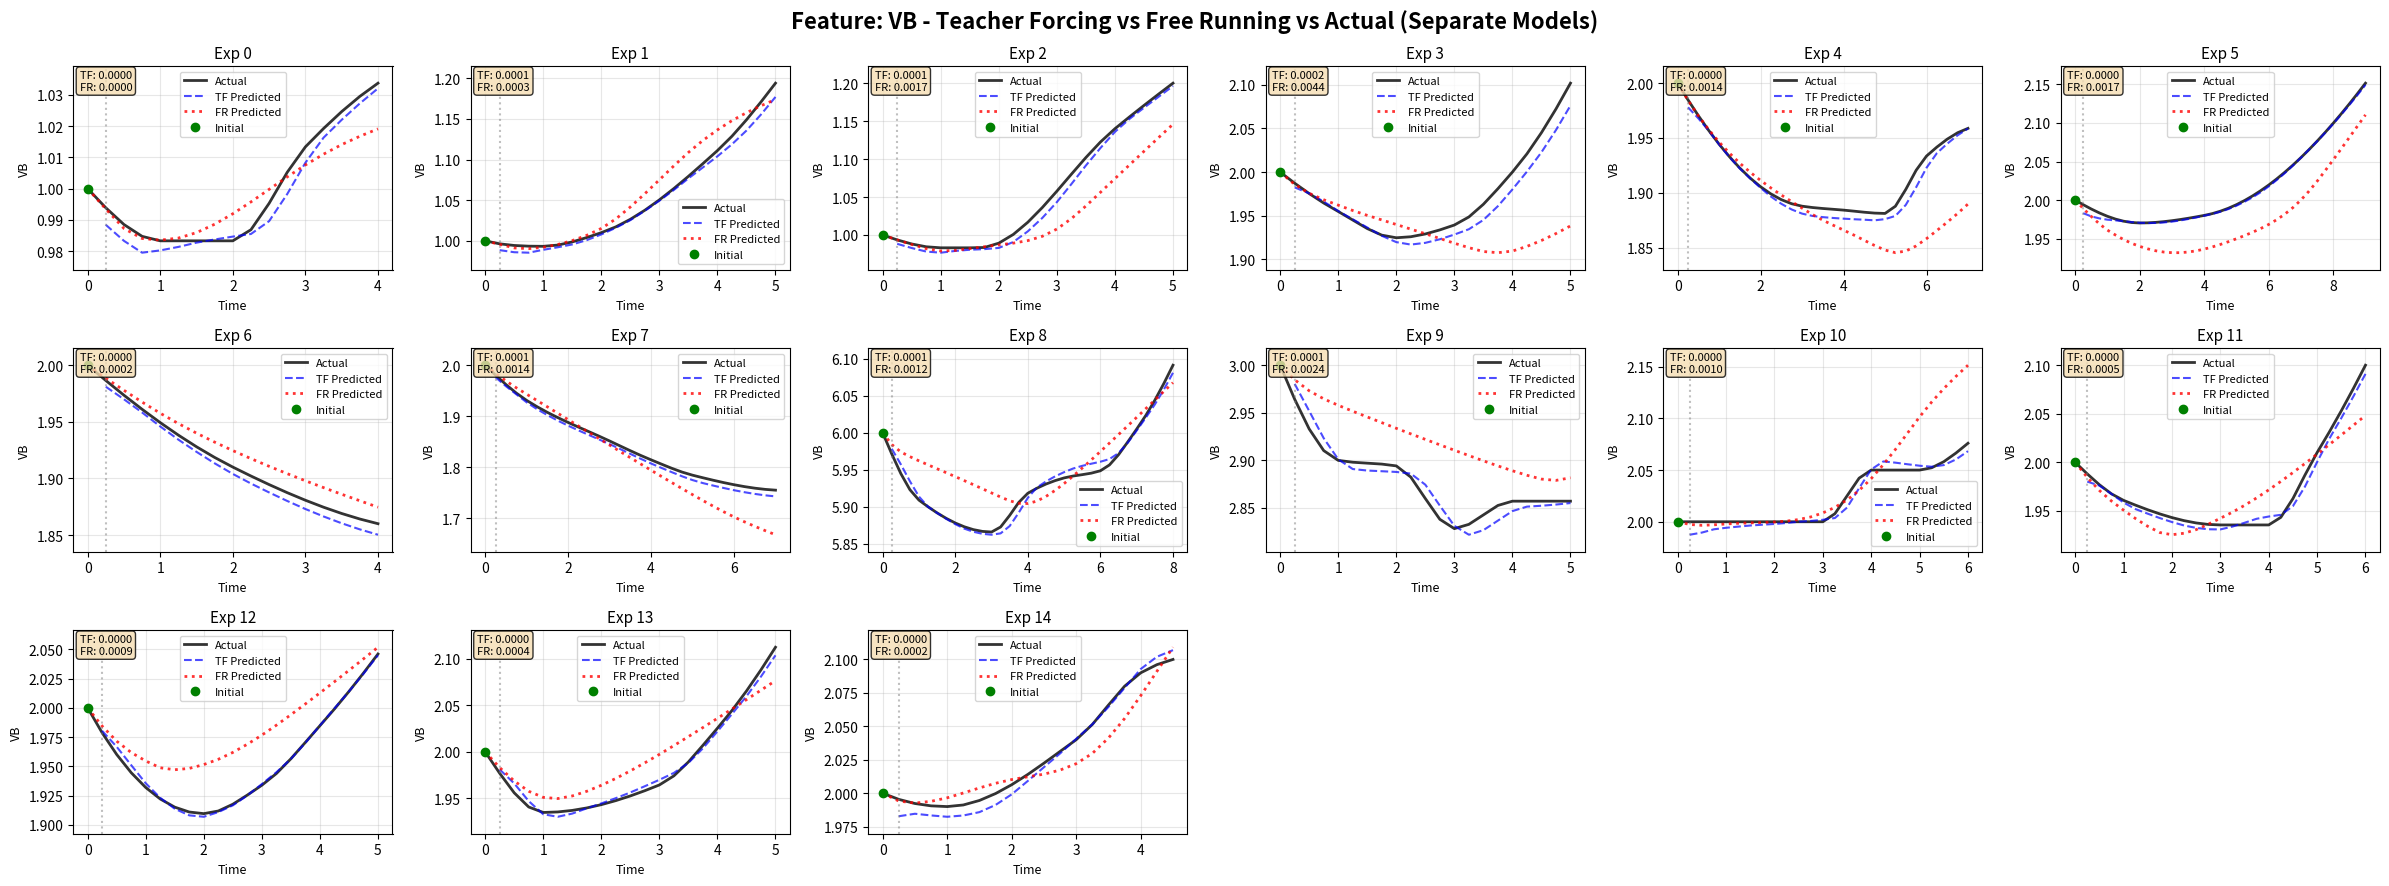

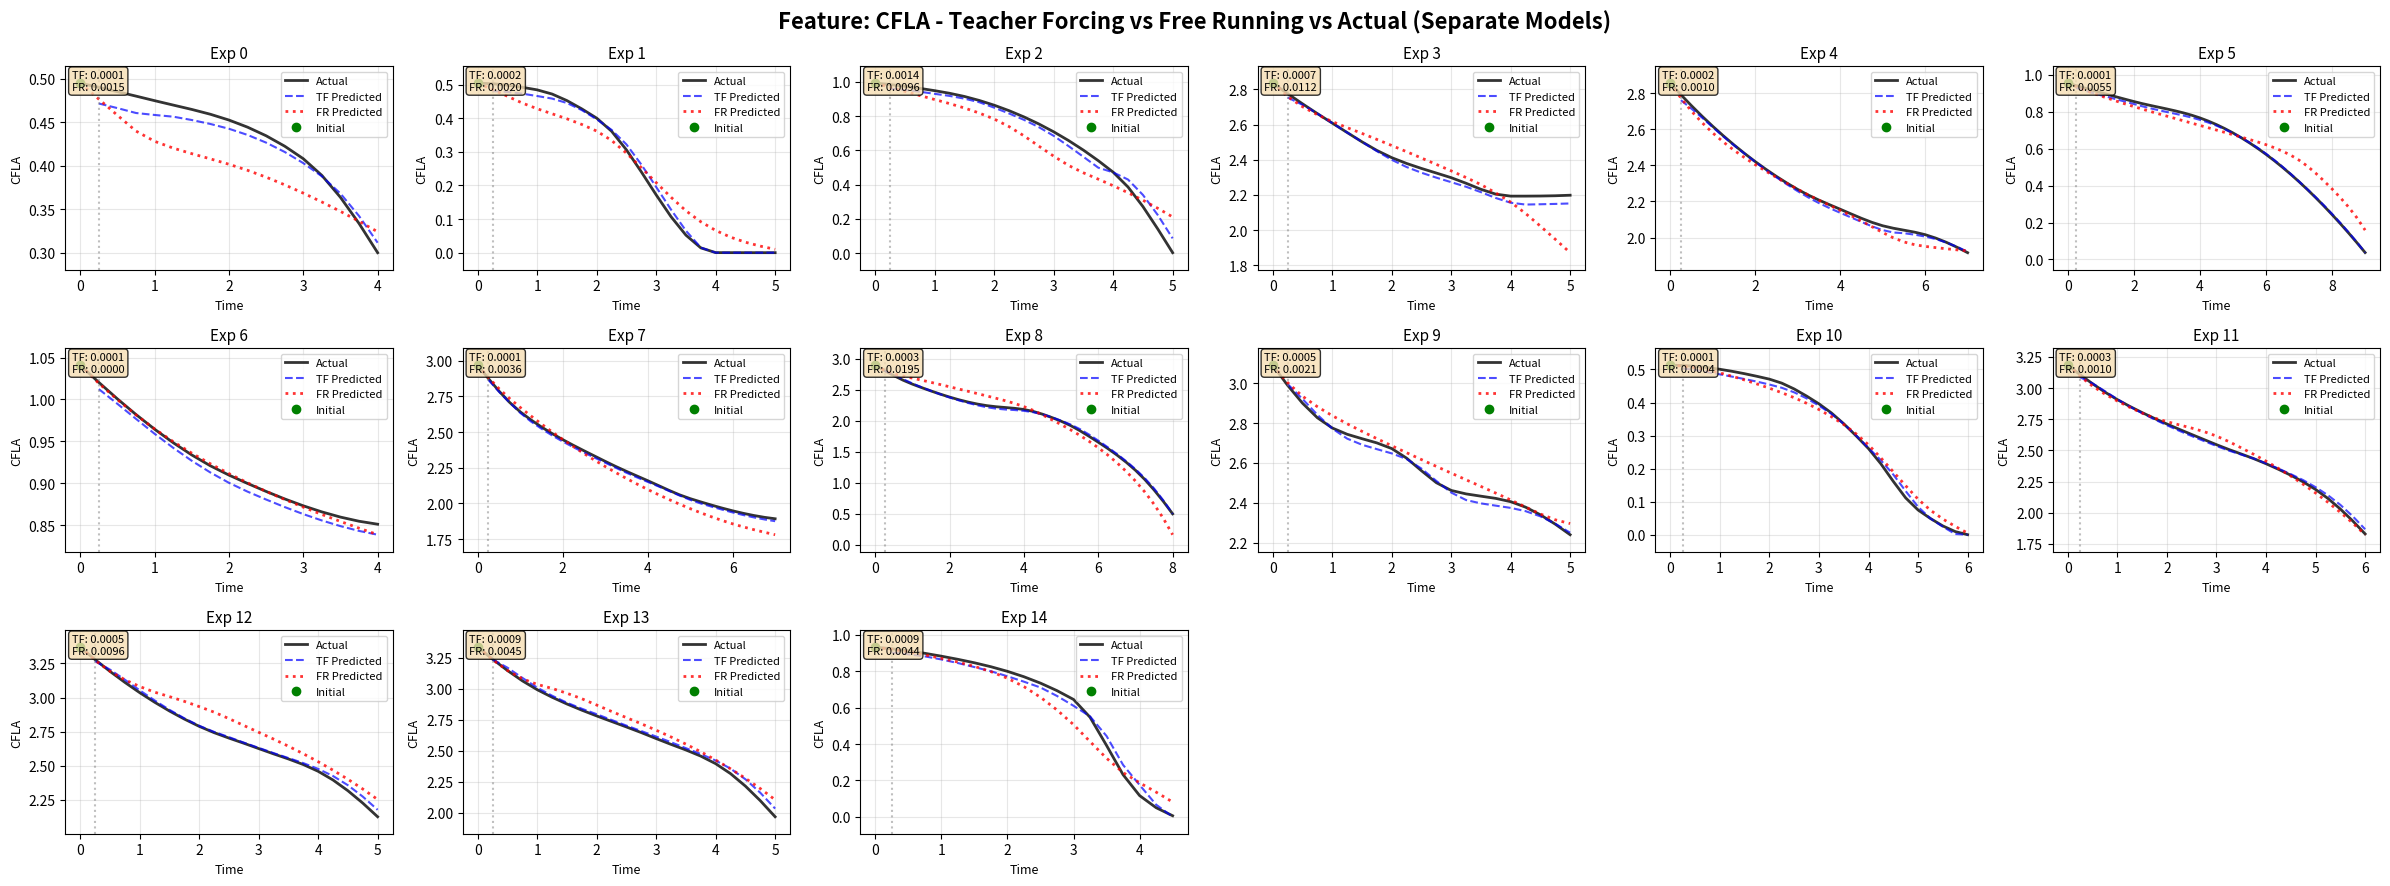

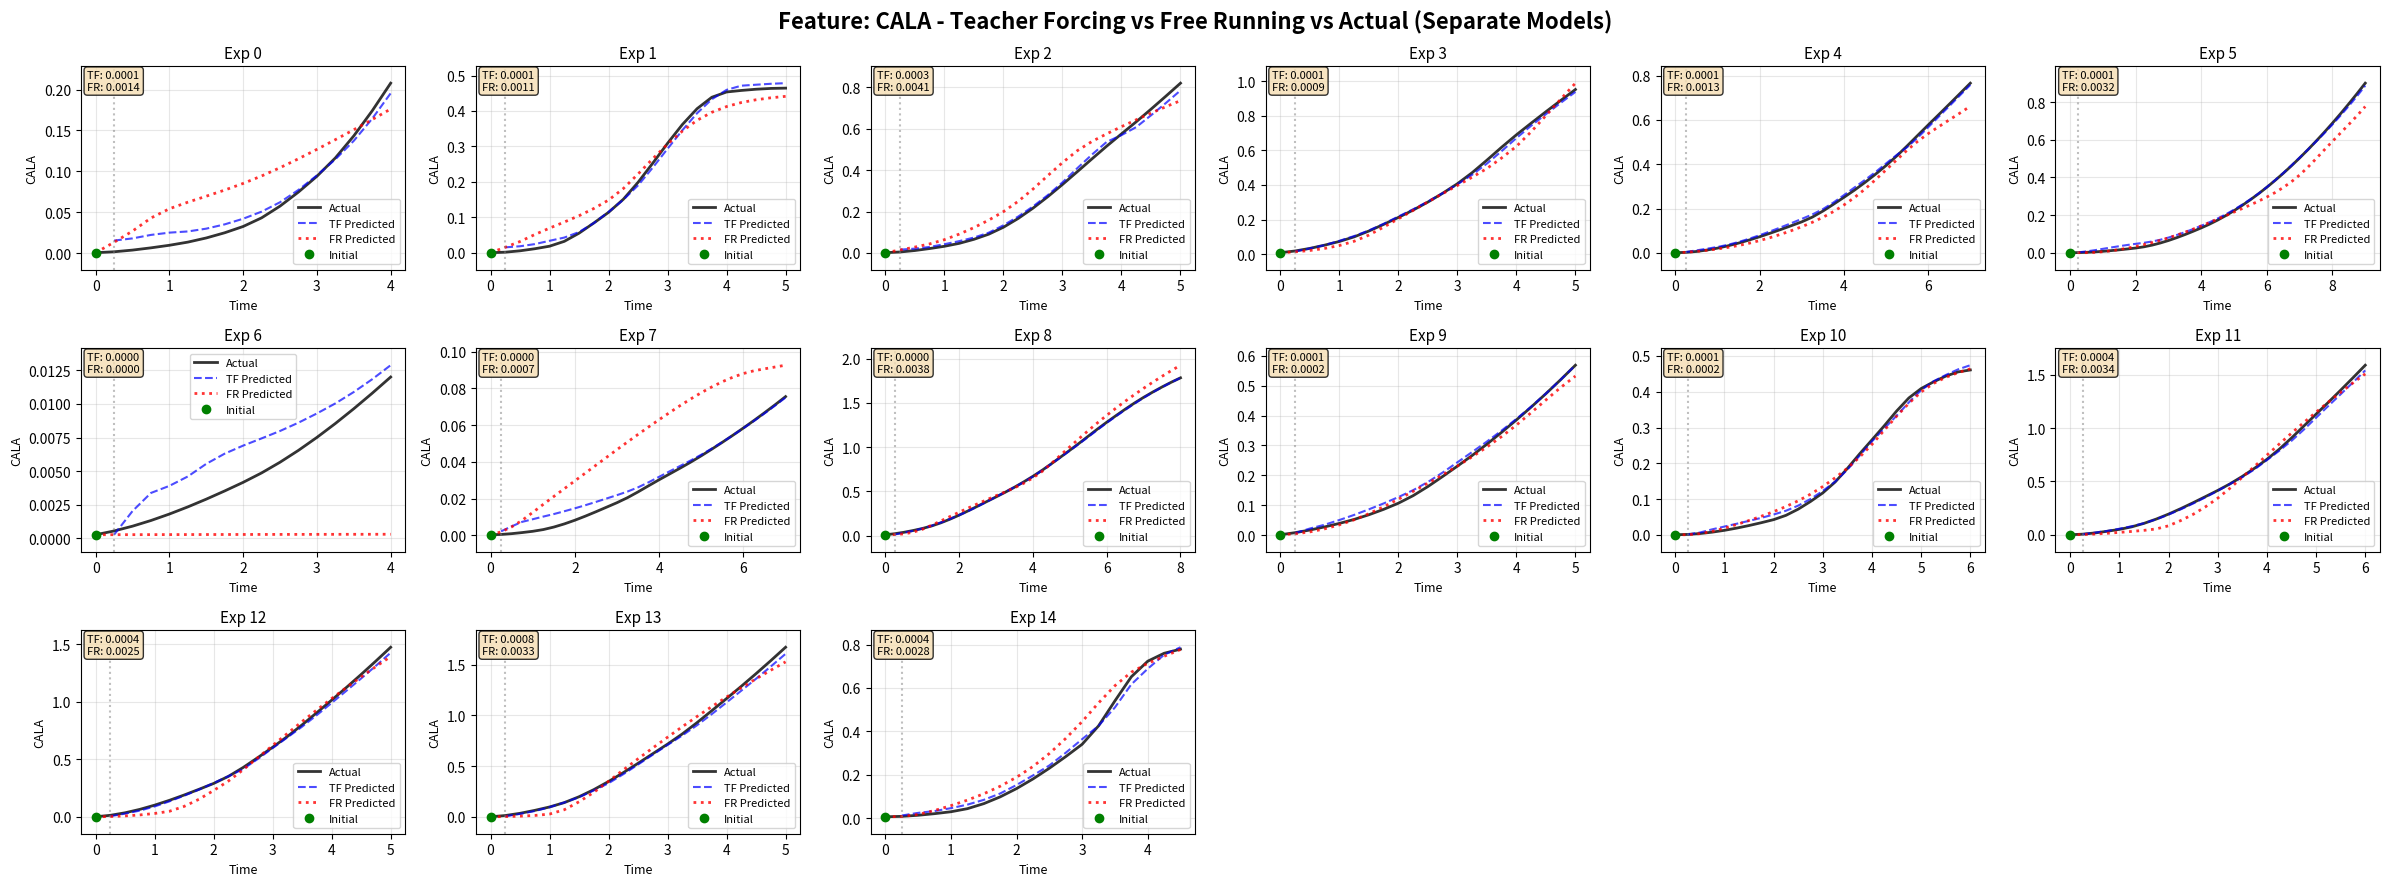

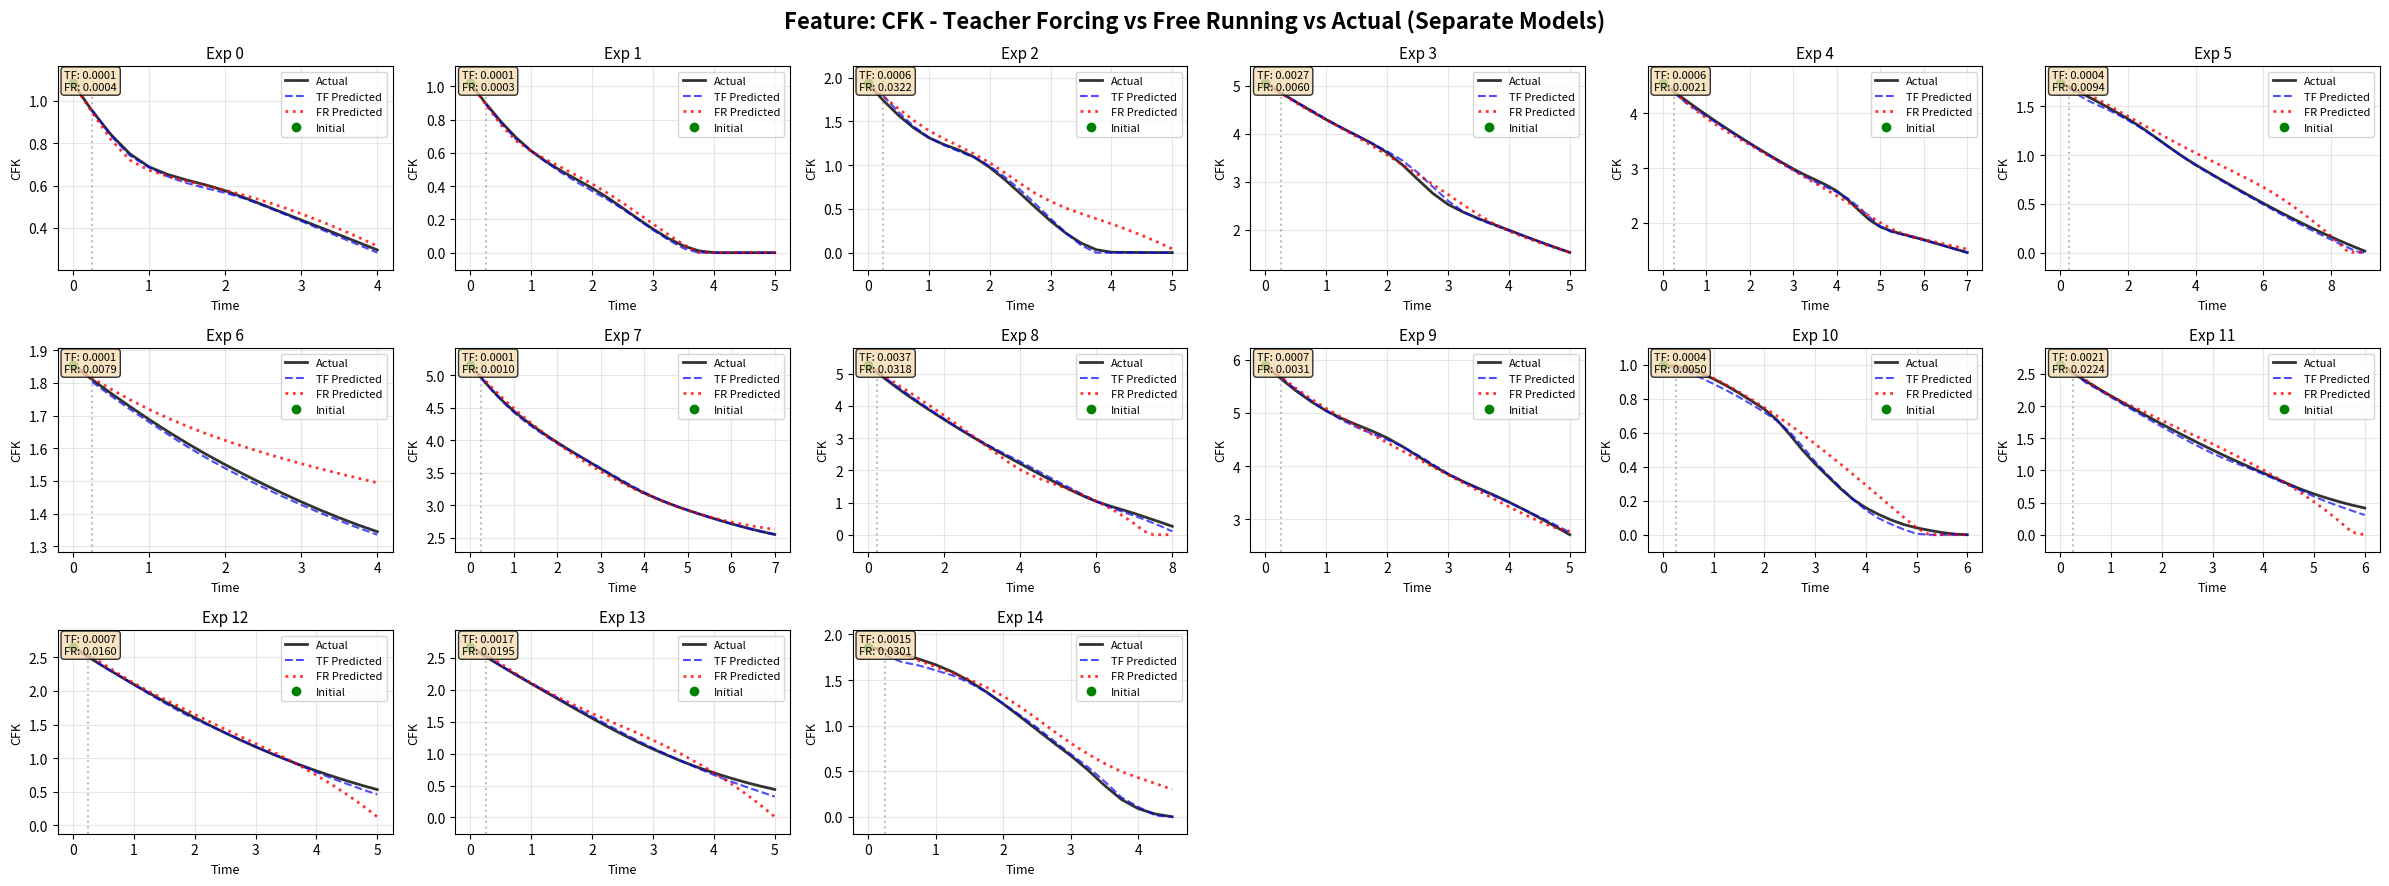

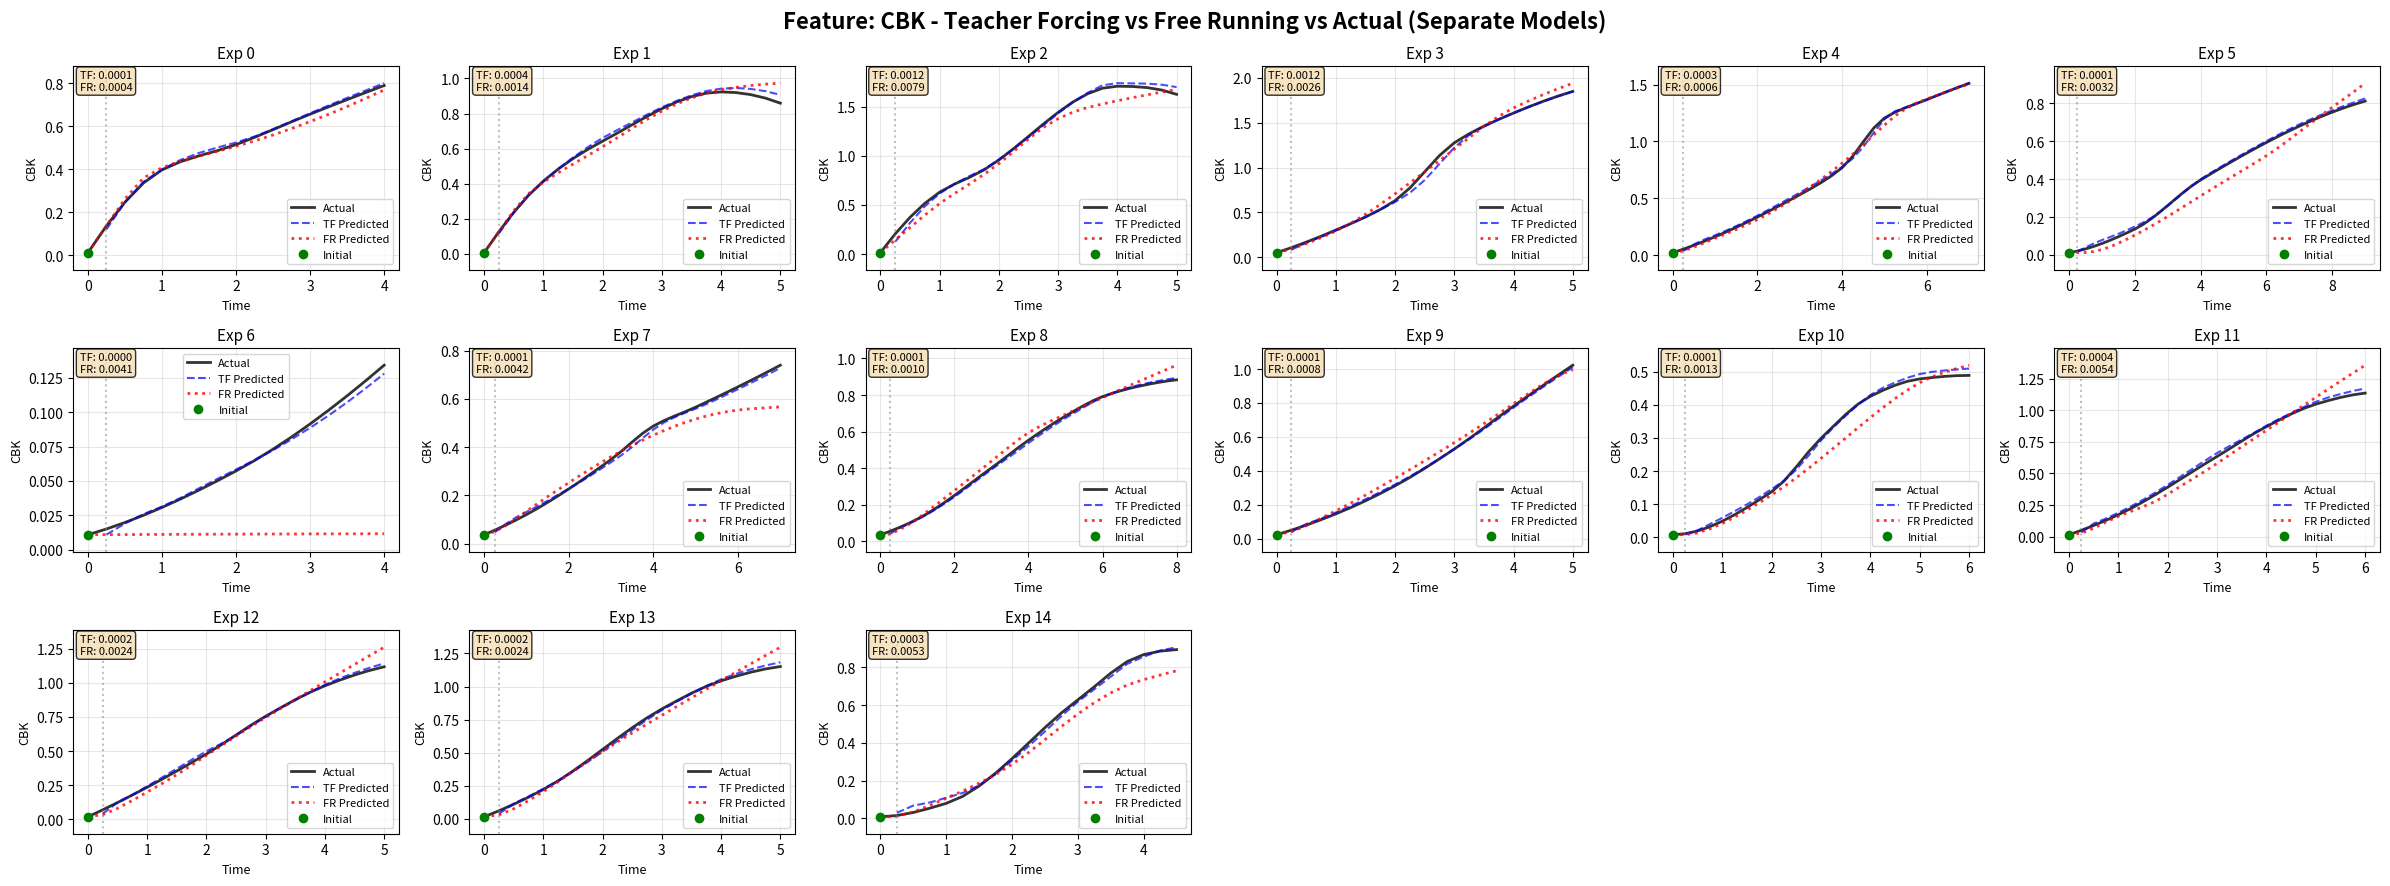

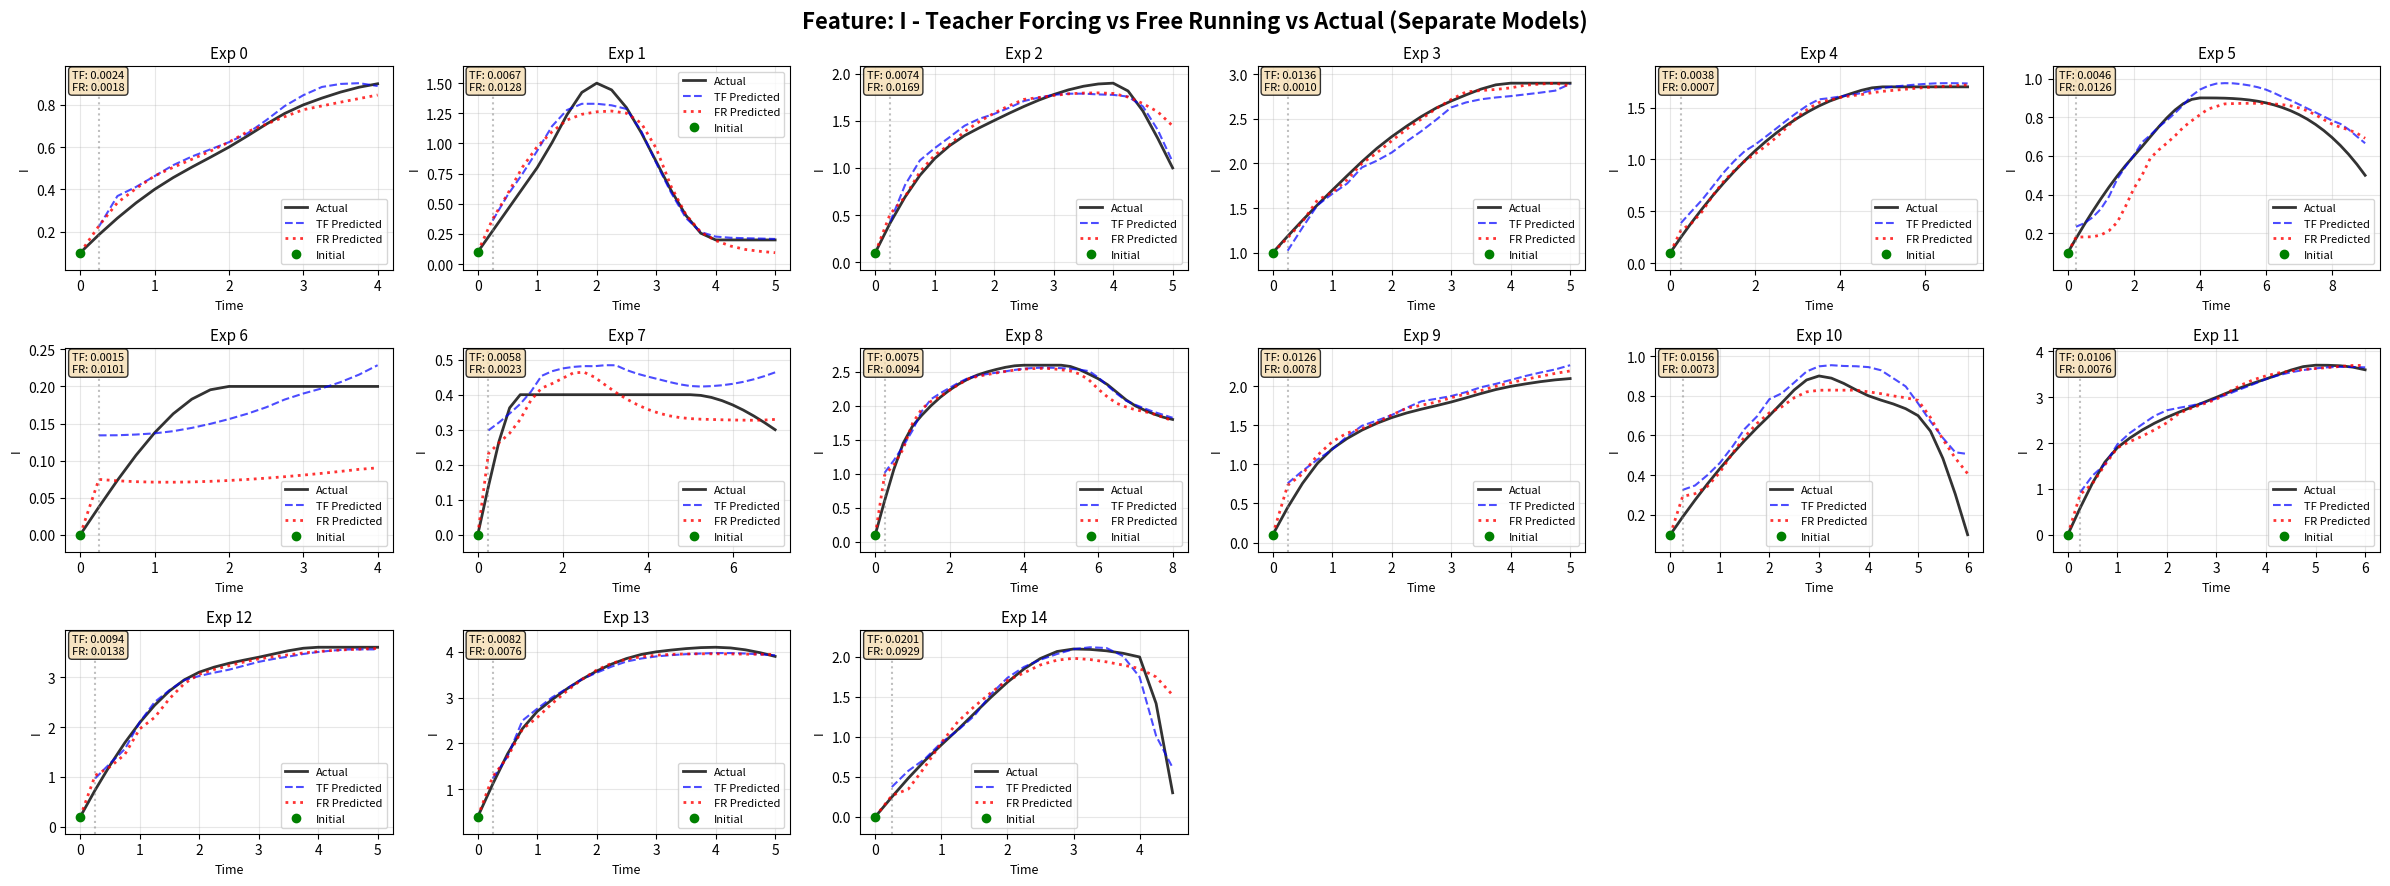

🎉 모든 feature에 대한 Teacher Forcing vs Free Running 비교 그래프 생성 완료!
📊 그래프 설명:
   - 검은색 실선: 실제값 (Actual)
   - 파란색 점선: Teacher Forcing 예측값 (BMED_TF_250909.pth 모델 사용)
   - 빨간색 점선: Free Running 예측값 (BMED_FR_250909.pth 모델 사용)
   - 초록색 점: 초기값
   - 회색 수직선: 예측 시작점
   - 각 subplot: 개별 실험 결과
   - V, E 제외한 8개 feature 모두 표시
   🎯 TF 모델과 FR 모델을 각각 사용하여 정확한 비교 분석!


In [ ]:
# Teacher Forcing vs Free Running 전체 실험 비교 시각화 - Feature별 Subplot (각각의 모델 사용)

print("🎯 Teacher Forcing vs Free Running 전체 실험 비교 시각화 (각각의 모델 사용)")
print("="*60)

# Teacher Forcing 전용 모델 로드
print("📥 Teacher Forcing 모델 로드 중: BMED_TF_250909.pth")
tf_checkpoint = torch.load("BMED_TF_250909.pth", map_location=device, weights_only=False)
tf_model = BMEDAutoregressiveModel(
    state_extr_params=tf_checkpoint['model_config']['state_extr_params'],
    decoder_params=tf_checkpoint['model_config']['decoder_params'],
    current_predictor_params=tf_checkpoint['model_config']['current_predictor_params'],
    range_mm=tf_checkpoint['model_config']['range_mm']
).to(device)
tf_model.load_state_dict(tf_checkpoint['model_state_dict'])
tf_model.eval()
print("✅ Teacher Forcing 모델 로드 완료!")

# Free Running 전용 모델 로드
print("📥 Free Running 모델 로드 중: BMED_FR_250910.pth")
fr_checkpoint = torch.load("BMED_FR_250910.pth", map_location=device, weights_only=False)
fr_model = BMEDAutoregressiveModel(
    state_extr_params=fr_checkpoint['model_config']['state_extr_params'],
    decoder_params=fr_checkpoint['model_config']['decoder_params'],
    current_predictor_params=fr_checkpoint['model_config']['current_predictor_params'],
    range_mm=fr_checkpoint['model_config']['range_mm']
).to(device)
fr_model.load_state_dict(fr_checkpoint['model_state_dict'])
fr_model.eval()
print("✅ Free Running 모델 로드 완료!")

# ✅ 현재 데이터의 range_mm을 사용하여 비정규화 함수 정의
def denormalize_data(normalized_data, feature_name):
    """현재 데이터 기준 정규화된 데이터를 원래 단위로 복원"""
    if feature_name in range_mm:
        min_val = range_mm[feature_name]['min']
        max_val = range_mm[feature_name]['max']
        return normalized_data * (max_val - min_val) + min_val
    return normalized_data

# 예측 결과와 실제 값을 저장할 딕셔너리
tf_predictions_dict = {}
fr_predictions_dict = {}
actual_dict = {}

# V와 E를 제외한 feature들의 인덱스와 이름
feature_names = ['VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
feature_indices = [2, 3, 4, 5, 6, 7, 8, 9]  # V(0), E(1)를 제외한 인덱스

# 전체 실험에 대해 예측 수행
with torch.no_grad():
    for exp_num in exp_num_list:
        # 실험 데이터 추출
        exp_data = ndf[ndf['exp'] == exp_num].copy()
        if len(exp_data) == 0:
            continue
        
        # 특성 컬럼들
        feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
        
        # 실험 데이터를 tensor로 변환
        exp_tensor = torch.tensor(exp_data[feature_cols].values).float().unsqueeze(0).to(device)  # [1, seq_len, 10]
        seq_length = len(exp_data)
        seq_len_tensor = torch.tensor([seq_length]).to(device)
        
        # Teacher Forcing 데이터 준비 및 예측 (TF 전용 모델 사용)
        tf_inputs, tf_targets, tf_seq_len = tf_data(exp_tensor, seq_len_tensor)
        tf_pred = tf_model(tf_inputs, tf_seq_len, mode='teacher_forcing')
        
        # Free Running 데이터 준비 및 예측 (FR 전용 모델 사용)
        fr_initial_states, fr_targets, fr_lengths = fr_data(exp_tensor, seq_len_tensor)
        initial_state = fr_initial_states  # [1, 10]
        target_length = int(fr_lengths[0].item())
        fr_pred = fr_model(initial_state, mode='free_running', target_length=target_length)
        
        # CPU로 이동하고 numpy 변환
        tf_pred_np = tf_pred[0].cpu().numpy()  # [seq_len-1, 10]
        fr_pred_np = fr_pred[0].cpu().numpy()  # [seq_len, 10]
        actual_tf_np = tf_targets[0].cpu().numpy()  # [seq_len-1, 10] (TF targets)
        actual_fr_np = fr_targets[0, :target_length].cpu().numpy()  # [seq_len, 10] (FR targets)
        
        # 딕셔너리에 저장
        tf_predictions_dict[exp_num] = tf_pred_np
        fr_predictions_dict[exp_num] = fr_pred_np
        actual_dict[exp_num] = {
            'tf': actual_tf_np,  # Teacher Forcing 타겟 (시점 1부터)
            'fr': actual_fr_np,  # Free Running 타겟 (전체 시퀀스)
            'time_tf': exp_data['t'].values[1:len(tf_pred_np)+1],  # TF 시간축
            'time_fr': exp_data['t'].values[:len(fr_pred_np)]      # FR 시간축
        }

print(f"✅ {len(tf_predictions_dict)}개 실험에 대한 예측 완료")

# V와 E를 제외한 각 feature별로 그래프 생성
for feat_idx, feat_name in zip(feature_indices, feature_names):
    # subplot 개수 계산 (행과 열 최적화)
    n_experiments = len(exp_num_list)
    n_cols = min(6, n_experiments)  # 최대 6열
    n_rows = (n_experiments + n_cols - 1) // n_cols  # 필요한 행 수
    
    # 그래프 크기 설정
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    fig.suptitle(f'Feature: {feat_name} - Teacher Forcing vs Free Running vs Actual (Separate Models)', fontsize=16, fontweight='bold')
    
    # subplot이 1개일 경우 리스트로 변환
    if n_experiments == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # 각 실험에 대해 subplot 생성
    for i, exp_num in enumerate(exp_num_list):
        row = i // n_cols
        col = i % n_cols
        
        if n_rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col] if n_cols > 1 else axes[0]
        
        # 예측값과 실제값 가져오기 (현재 데이터 range_mm으로 비정규화)
        if exp_num in tf_predictions_dict:
            tf_pred_values = denormalize_data(tf_predictions_dict[exp_num][:, feat_idx], feat_name)
            fr_pred_values = denormalize_data(fr_predictions_dict[exp_num][:, feat_idx], feat_name)
            tf_actual_values = denormalize_data(actual_dict[exp_num]['tf'][:, feat_idx], feat_name)
            fr_actual_values = denormalize_data(actual_dict[exp_num]['fr'][:, feat_idx], feat_name)
            tf_time = actual_dict[exp_num]['time_tf'][:len(tf_pred_values)]
            fr_time = actual_dict[exp_num]['time_fr'][:len(fr_pred_values)]
            
            # 그래프 그리기
            # 실제값 (Free Running은 전체, Teacher Forcing은 시점 1부터)
            ax.plot(fr_time, fr_actual_values, 'k-', linewidth=2, label='Actual', alpha=0.8)
            
            # Teacher Forcing 예측 (시점 1부터)
            ax.plot(tf_time, tf_pred_values, 'b--', linewidth=1.5, label='TF Predicted', alpha=0.7)
            
            # Free Running 예측 (전체 시퀀스)
            ax.plot(fr_time, fr_pred_values, 'r:', linewidth=2, label='FR Predicted', alpha=0.8)
            
            # 초기값 표시
            if len(fr_actual_values) > 0:
                ax.plot(fr_time[0], fr_actual_values[0], 'go', markersize=6, label='Initial')
            
            # 예측 시작점 표시
            if len(fr_time) > 1:
                ax.axvline(x=fr_time[1], color='gray', linestyle=':', alpha=0.5)
            
            # 그래프 설정
            ax.set_title(f'Exp {exp_num}', fontsize=11)
            ax.set_xlabel('Time', fontsize=9)
            ax.set_ylabel(feat_name, fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)
            
            # MSE 계산 및 표시 (비정규화된 값으로)
            tf_mse = np.mean((tf_actual_values - tf_pred_values)**2) if len(tf_pred_values) > 0 else 0
            fr_mse = np.mean((fr_actual_values - fr_pred_values)**2) if len(fr_pred_values) > 0 else 0
            
            # 텍스트 박스로 MSE 표시
            textstr = f'TF: {tf_mse:.4f}\nFR: {fr_mse:.4f}'
            ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=8,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            # y축 범위 설정
            all_values = np.concatenate([tf_actual_values, fr_actual_values, tf_pred_values, fr_pred_values])
            y_min, y_max = all_values.min(), all_values.max()
            y_range = y_max - y_min
            if y_range > 0:
                ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
        else:
            ax.text(0.5, 0.5, f'No data\nExp {exp_num}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # 빈 subplot 제거
    for i in range(n_experiments, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows > 1:
            axes[row, col].remove()
        else:
            if n_cols > 1:
                axes[col].remove()
    
    plt.tight_layout()
    plt.show()

print("🎉 모든 feature에 대한 Teacher Forcing vs Free Running 비교 그래프 생성 완료!")
print("📊 그래프 설명:")
print("   - 검은색 실선: 실제값 (Actual)")
print("   - 파란색 점선: Teacher Forcing 예측값 (BMED_TF_250909.pth 모델 사용)")
print("   - 빨간색 점선: Free Running 예측값 (BMED_FR_250909.pth 모델 사용)")
print("   - 초록색 점: 초기값")
print("   - 회색 수직선: 예측 시작점")
print("   - 각 subplot: 개별 실험 결과")
print("   - V, E 제외한 8개 feature 모두 표시")
print("   🎯 TF 모델과 FR 모델을 각각 사용하여 정확한 비교 분석!")